In [1]:
import math
from collections import defaultdict
import random
import matplotlib.pyplot as plt

In [2]:
def winner(board):
    lines = [(0,1,2),(3,4,5),(6,7,8),
             (0,3,6),(1,4,7),(2,5,8),
             (0,4,8),(2,4,6)]
    for a,b,c in lines:
        if board[a] != ' ' and board[a]==board[b]==board[c]:
            return board[a]
    return None

def is_full(board): return ' ' not in board
def is_terminal(board): return winner(board) or is_full(board)
def legal_moves(board): return [i for i,ch in enumerate(board) if ch==' ']
def apply_move(board, pos, mark):
    lst = list(board)
    lst[pos] = mark
    return ''.join(lst)

# MDP formulation
def transitions_from(state, action):
    after_x = apply_move(state, action, 'X')
    if winner(after_x) == 'X':
        return [(1.0, after_x, 1.0, True)]
    if is_full(after_x):
        return [(1.0, after_x, 0.0, True)]

    opp_moves = legal_moves(after_x)
    p = 1.0 / len(opp_moves)
    transitions = []
    for om in opp_moves:
        after_o = apply_move(after_x, om, 'O')
        if winner(after_o) == 'O':
            transitions.append((p, after_o, -1.0, True))
        elif is_full(after_o):
            transitions.append((p, after_o, 0.0, True))
        else:
            transitions.append((p, after_o, 0.0, False))
    return transitions

# Value iteration algorithm
def value_iteration(gamma=1.0, theta=1e-6):
    # Generate all states
    states = set()
    stack = [(' ' * 9, 'X')]
    visited = set(stack)
    
    while stack:
        board, to_move = stack.pop()
        if to_move == 'X':
            states.add(board)
        if is_terminal(board):
            continue
        for mv in legal_moves(board):
            nb = apply_move(board, mv, to_move)
            nxt = 'O' if to_move=='X' else 'X'
            if (nb, nxt) not in visited:
                visited.add((nb, nxt))
                stack.append((nb, nxt))
    
    # Initialize value function
    V = {s: 0.0 for s in states}
    policy = {s: None for s in states}
    
    # Value iteration
    delta = float('inf')
    while delta > theta:
        delta = 0.0
        for s in states:
            if is_terminal(s):
                continue
            best_val, best_a = -math.inf, None
            for a in legal_moves(s):
                exp_val = 0.0
                for p, ns, r, done in transitions_from(s, a):
                    if done:
                        exp_val += p * r
                    else:
                        exp_val += p * (r + gamma * V[ns])
                if exp_val > best_val:
                    best_val, best_a = exp_val, a
            delta = max(delta, abs(V[s]-best_val))
            V[s], policy[s] = best_val, best_a
    
    return V, policy

if __name__ == "__main__":
    # Solve MDP using value iteration
    V, policy = value_iteration()
    
    # Report results
    initial_state = ' ' * 9
    print(f"Value of initial state: {V[initial_state]:.3f}")
    print(f"Optimal first move: Position {policy[initial_state]}")

Value of initial state: 0.995
Optimal first move: Position 0


Q-learning Results:
Wins: 959, Losses: 14, Draws: 27
Win rate: 0.959


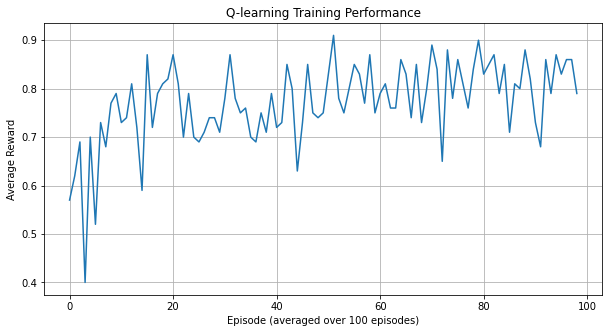


DP Policy Results:
Wins: 994, Losses: 0, Draws: 6
Win rate: 0.994


In [4]:
def winner(board):
    lines = [(0,1,2),(3,4,5),(6,7,8),
             (0,3,6),(1,4,7),(2,5,8),
             (0,4,8),(2,4,6)]
    for a,b,c in lines:
        if board[a] != ' ' and board[a]==board[b]==board[c]:
            return board[a]
    return None

def is_full(board): return ' ' not in board
def is_terminal(board): return winner(board) or is_full(board)
def legal_moves(board): return [i for i,ch in enumerate(board) if ch==' ']
def apply_move(board, pos, mark):
    lst = list(board)
    lst[pos] = mark
    return ''.join(lst)

# Q-learning 
def train_qlearning(episodes=10000, alpha=0.1, gamma=1.0, epsilon=0.2):
    Q = defaultdict(float)
    rewards = []
    
    for _ in range(episodes):
        board = ' ' * 9
        done = False
        episode_reward = 0
        
        while not done:
            # X turn
            actions = legal_moves(board)
            if not actions:
                break
                
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.choice(actions)
            else:
                best_val = -float('inf')
                for a in actions:
                    if Q[(board, a)] > best_val:
                        best_val = Q[(board, a)]
                        action = a
            
            # Apply action
            next_board = apply_move(board, action, 'X')
            
            # Check if game ended
            if winner(next_board) == 'X':
                reward = 1
                done = True
            elif is_full(next_board):
                reward = 0
                done = True
            else:
                # Opponent's turn
                opp_actions = legal_moves(next_board)
                if not opp_actions:
                    reward = 0
                    done = True
                else:
                    opp_action = random.choice(opp_actions)
                    next_board = apply_move(next_board, opp_action, 'O')
                    
                    if winner(next_board) == 'O':
                        reward = -1
                        done = True
                    elif is_full(next_board):
                        reward = 0
                        done = True
                    else:
                        reward = 0
                        done = False
            
            # Q-learning update
            if done:
                Q[(board, action)] += alpha * (reward - Q[(board, action)])
            else:
                next_actions = legal_moves(next_board)
                if next_actions:
                    max_next = max(Q[(next_board, a)] for a in next_actions)
                    Q[(board, action)] += alpha * (reward + gamma * max_next - Q[(board, action)])
            
            board = next_board
            episode_reward += reward
        
        rewards.append(episode_reward)
    
    return Q, rewards

def evaluate_policy(Q, n_games=1000):
    wins, losses, draws = 0, 0, 0
    
    for _ in range(n_games):
        board = ' ' * 9
        done = False
        
        while not done:
            # Agent's turn
            actions = legal_moves(board)
            if not actions:
                draws += 1
                break
                
            # Choose best action
            best_val = -float('inf')
            for a in actions:
                if Q[(board, a)] > best_val:
                    best_val = Q[(board, a)]
                    action = a
            
            board = apply_move(board, action, 'X')
            
            if winner(board) == 'X':
                wins += 1
                break
            if is_full(board):
                draws += 1
                break
                
            # Opponent's turn
            opp_actions = legal_moves(board)
            if not opp_actions:
                draws += 1
                break
                
            opp_action = random.choice(opp_actions)
            board = apply_move(board, opp_action, 'O')
            
            if winner(board) == 'O':
                losses += 1
                break
            if is_full(board):
                draws += 1
                break
    
    return wins, losses, draws

if __name__ == "__main__":
    # Train Q-learning agent
    Q, rewards = train_qlearning()
    
    # Evaluate policy
    wins, losses, draws = evaluate_policy(Q)
    
    # Compare with DP solution
    V, dp_policy = value_iteration()
    
    # Evaluate DP policy
    dp_wins, dp_losses, dp_draws = 0, 0, 0
    for _ in range(1000):
        board = ' ' * 9
        done = False
        
        while not done:
            # DP policy's turn
            if board in dp_policy and dp_policy[board] is not None:
                action = dp_policy[board]
            else:
                actions = legal_moves(board)
                if not actions:
                    dp_draws += 1
                    break
                action = random.choice(actions)
            
            board = apply_move(board, action, 'X')
            
            if winner(board) == 'X':
                dp_wins += 1
                break
            if is_full(board):
                dp_draws += 1
                break
                
            # Opponent's turn
            opp_actions = legal_moves(board)
            if not opp_actions:
                dp_draws += 1
                break
                
            opp_action = random.choice(opp_actions)
            board = apply_move(board, opp_action, 'O')
            
            if winner(board) == 'O':
                dp_losses += 1
                break
            if is_full(board):
                dp_draws += 1
                break
                
    print("Q-learning Results:")
    print(f"Wins: {wins}, Losses: {losses}, Draws: {draws}")
    print(f"Win rate: {wins/(wins+losses+draws):.3f}")
    
    # Plot training curve
    window = 100
    avg_rewards = []
    for i in range(0, len(rewards) - window, window):
        avg_rewards.append(sum(rewards[i:i+window]) / window)
    
    plt.figure(figsize=(10, 5))
    plt.plot(avg_rewards)
    plt.title("Q-learning Training Performance")
    plt.xlabel("Episode (averaged over 100 episodes)")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.savefig("training_curve.png")
    plt.show()
    
    print("\nDP Policy Results:")
    print(f"Wins: {dp_wins}, Losses: {dp_losses}, Draws: {dp_draws}")
    print(f"Win rate: {dp_wins/(dp_wins+dp_losses+dp_draws):.3f}")
    